In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from sklearn.model_selection import train_test_split
import os
from nltk.tokenize import TweetTokenizer

In [2]:
import tensorflow_hub as hub
#import keras
from keras import backend as K
from keras.models import Model, Input
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from keras.models import model_from_json

Using TensorFlow backend.


# Обработка входных данных
1. Считывание файла перекодированного в utf-8 в базу данных
1. Описание полученных данных
1. Формирование Массивов для обучения модели

### Файл с входными данными "data.txt" был конвертирован в файл "data_utf.txt" с кодировкой utf-8

In [3]:
def read_txt_to_dataframe(path):
    #txt файл перекодирован в формат utf-8 для безпроблемной (почти безпроблемной читаемости)
    columns=['Sentence #', 'text', 'tag']
    data = pd.DataFrame([], columns=columns)
    with io.open(path, encoding='utf-8') as file:
        sentence = []
        sentence_number = 0
        for line in file:
            if len(line.split(' '))!=2:
                try:
                    #data.append(sentence)
                    df = pd.DataFrame(sentence, columns = columns)
                    data = data.append(df, ignore_index = True)
                    sentence_number +=1
                    sentence = []
                except:
                    print('Error while trying to form DataFrame')
            else:
                word = line.split(' ')
                try:
                    sentence.append([sentence_number, word[0], word[1][:-1]])
                except:
                    print('Error while reading or parsing data from file')
    return data         

In [4]:
%%time
data = read_txt_to_dataframe('data_utf.txt')
print('Вид DataFrame')
data.head(20)

Вид DataFrame
Wall time: 1min 50s


,Sentence #,text,tag
0,0,﻿Man,O
1,0,i,O
2,0,hate,O
3,0,when,O
4,0,people,O
5,0,carry,O
6,0,ragedy,O
7,0,luggage,O
8,0,..,O
9,0,ima,O


In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(p, t) for w, p, t in zip(s[data.columns[0]].values.tolist(),
                                                           s[data.columns[1]].values.tolist(),
                                                           s[data.columns[2]].values.tolist())]
        self.grouped = self.data.groupby(['Sentence #']).apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('Этот класс позволяет считывать предложения (твиты) из базы данных по очереди:')
print(sent)

Этот класс позволяет считывать предложения (твиты) из базы данных по очереди:
[('\ufeffMan', 'O'), ('i', 'O'), ('hate', 'O'), ('when', 'O'), ('people', 'O'), ('carry', 'O'), ('ragedy', 'O'), ('luggage', 'O'), ('..', 'O'), ('ima', 'O'), ('just', 'O'), ('rip', 'O'), ('it', 'O'), ('up', 'O'), ('more', 'O'), ('with', 'O'), ('the', 'O'), ('belt', 'O'), ('loader', 'O'), ('#itaintmines', 'O')]


## Описание данных в базе: 
1. количество записей 
1. уникальные значения по каждой из колонок
1. Частоту каждой из меток во всех токенах

In [7]:
#Описание данных в базе
print(data.describe())
print('Уникальных значений в колонках:\n', data.describe().iloc[1], '\n')
print()

        Sentence #    text     tag
count       124629  124629  124629
unique        7243   28820      21
top           4654       .       O
freq            41    3495  115084
Уникальных значений в колонках:
 Sentence #     7243
text          28820
tag              21
Name: unique, dtype: object 




In [8]:
print('Пропусков в базе данных быть не должно в каждой из колоник:\n')
print(data.count() - data.notna().count())

Пропусков в базе данных быть не должно в каждой из колоник:

Sentence #    0
text          0
tag           0
dtype: int64


In [9]:
stat = data.groupby(['tag']).tag.count().reset_index(name = 'count').sort_values(['count'], ascending = False)
stat                   

,tag,count
20,O,115084
2,B-geo-loc,1274
6,B-person,1102
15,I-other,973
5,B-other,941
0,B-company,831
17,I-product,701
16,I-person,610
11,I-facility,510
1,B-facility,395


Мы имеем базу твитов разбитых по токенам из 7243 твитов. Общее количество токенов 124629.
Самое большое количество проставленных меток относится к классу "O" (очевидно).
Далее идут метки ['B-geo-loc', 'B-person', 'I-other', 'B-other', 'B-company'] с частотой в диапазоне [800,2000]
Скорей всего самые плохие результаты будут на самых немногочисленных метках с частотой меньше 200.

Далее посчитаем распределение твитов по длине и выясним максиальную длину предложения

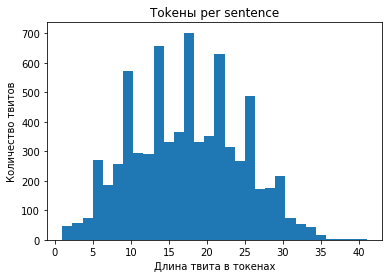

In [10]:
# Получим список твитов разбитый по токенам
sentences = getter.sentences

# Распределение твитов по количеству токенов
plt.hist([len(s) for s in sentences], bins=30, align='mid')
plt.title('Tokens per sentence')
plt.xlabel('Длина твита в токенах')
plt.ylabel('Количество твитов')
plt.show()

Срредняя длина твита $\approx 17$ токенов

In [11]:
max_len = np.max([len(x) for x in sentences])
print('Самое днинный твит состоит из %i токенов' % max_len)

Самое днинный твит состоит из 41 токенов


In [12]:
# Составим лист из всех выделенных токенов
words_list = list(set(data['text'].values))
words_list.append('__PAD__')
n_words = len(words_list)
print('Словарь состоит из %i слов' % n_words)

Словарь состоит из 28821 слов


In [13]:
# Составим лист всех меток классов
tags_list = list(set(data['tag'].values))
n_tags = len(tags_list)
print('Всего имеем %i метка' % n_tags)
for i, tag in enumerate(tags_list):
    print(i, ': ', tag)

Всего имеем 21 метка
0 :  B-other
1 :  I-tvshow
2 :  B-sportsteam
3 :  I-geo-loc
4 :  B-company
5 :  I-movie
6 :  I-product
7 :  I-sportsteam
8 :  B-facility
9 :  I-other
10 :  I-musicartist
11 :  I-person
12 :  B-tvshow
13 :  B-product
14 :  I-company
15 :  B-geo-loc
16 :  O
17 :  B-musicartist
18 :  B-movie
19 :  B-person
20 :  I-facility


##### Зададим максимальную длину твита с небольшим запасом (в данном случае 50)

In [14]:
max_len = 50
tag2idx = {t: i for i, t in enumerate(tags_list)}

Чтобы передать твиты в модель необходимо дополнить каждый твит до длины MAX_LEN уникальным токеном "__PAD__". То же самое делаем с массивом меток.

In [15]:
#Дополняем каждый твит до длины MAX_LEN
X = np.array([[w[0] for w in s] for s in sentences])
#print(X[10])
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X = np.array(new_X)
print('Так выглядит токенизированный твит для обучения модели')
print(X[10])

['Just', 'In', ':', 'University', 'of', 'Illinois', 'Chancellor', 'Wise', 'resigning', 'Aug', '.', '12', 'http://t.co/1bwas7bJUl']
Так выглядит токенищированный твит для обучения модели
['Just' 'In' ':' 'University' 'of' 'Illinois' 'Chancellor' 'Wise'
 'resigning' 'Aug' '.' '12' 'http://t.co/1bwas7bJUl' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__']


In [16]:
#Дополняем каждый вектор меток до длины MAX_LEN
y = [[tag2idx[w[1]] for w in s] for s in sentences]
print('Исходная длина: ', len(y[10]), '\nВектор меток: ', y[10])
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
print('Преобразованная длина: ', len(y[10]), '\nНовый вектор меток: ', y[10])

Исходная длина:  13 
Вектор меток:  [16, 16, 16, 0, 9, 9, 19, 11, 16, 16, 16, 16, 16]
Преобразованная длина:  50 
Новый вектор меток:  [16 16 16  0  9  9 19 11 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16]


In [17]:
#Разделяем выборку на 
#Обрезаем обучающую выборку для корректоного обучения слоя LSTM по параметру batch_size
def get_train_test_data(X,y, batch_size):
    
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=2018)
    batch_size = 32
    X_train = np.copy(X_tr[0:X_tr.shape[0]//batch_size*batch_size]) 
    X_val   = np.copy(X_te[0:X_te.shape[0]//batch_size*batch_size])
    y_train = np.copy(y_tr[0:y_tr.shape[0]//batch_size*batch_size])
    y_val   = np.copy(y_te[0:y_te.shape[0]//batch_size*batch_size])
    #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    y_train = y_train.reshape(y_train.shape[0], y_train.shape[1],1)
    #X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    y_val = y_val.reshape(y_val.shape[0], y_val.shape[1],1)
    return X_train, X_val, y_train, y_val

# Модель решения
Bidirectional LSTM для семантического анализа текстово были предложены в большом колечетве статей
Несколько примеров.
https://doi.org/10.18653/v1/W17-4421
https://doi.org/10.17863/CAM.7201

Кроме того для увеличения качества модели использована предобученная сеть ELMO (https://allennlp.org/elmo) для создания вложенного слоя, который чувствителен к контексту в отличе от других слоев который были бы обучены на тестовой выборке.
Конечная модель взята из материала: 
https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/

Итоговый вид модели Состоит из
1. Слоя ELMO Embedding
1. Двух связанных слоев LSTM
1. Полносвязного слоя для вывода итоговых классов



In [18]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]
def initialise_sess():
    sess = tf.Session()
    K.set_session(sess)
    #инициализация ELMO EMbedding
    elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
    #sess.run(tf.global_variables_initializer())
    #sess.run(tf.tables_initializer())
    sess.run(tf.group([tf.global_variables_initializer(), tf.tables_initializer()]))
    return sess


In [27]:
#Гиперпараметры модели
lstm_size = 256 #Размер LSTM слоев
epochs = 3 # Кол-во итераций обучения
verbose = 1 # Вид вывода прогресса обучения
batch_size = 32 # Частота обновления весов модели (точнее кол-во итерации между обновлениями)

sess = tf.Session()
K.set_session(sess)
#инициализация ELMO EMbedding
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=False)
init_op = tf.global_variables_initializer()
sess.run(init_op)
# Построение слоев
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=lstm_size, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=lstm_size, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
#компиляция модели
model = Model(input_text, out)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["categorical_accuracy"])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0814 13:35:59.979997  8996 saver.py:1483] Saver not created because there are no variables in the graph to restore


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 50, 1024)     0           input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 50, 512)      2623488     lambda_3[0][0]                   
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 50, 512)      1574912     bidirectional_5[0][0]            
__________________________________________________________________________________________________
add_3 (Add

In [20]:
# Метод для Сохранения модели в файл
def save_model(model_path):
    v1 = tf.get_variable("v1", shape=[3], initializer = tf.zeros_initializer)
    v2 = tf.get_variable("v2", shape=[5], initializer = tf.zeros_initializer)

    inc_v1 = v1.assign(v1+1)
    dec_v2 = v2.assign(v2-1)
    
    # Add an op to initialize the variables.
    init_op = tf.global_variables_initializer()

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(init_op)
        # Do some work with the model.
        inc_v1.op.run()
        dec_v2.op.run()
        # Save the variables to disk.
        save_path = saver.save(sess, model_path)
        print("Model saved in path: %s" % save_path)

In [21]:
#Метод для Загрузки модели из файла
def load_model(model_path):
    tf.reset_default_graph()
    
    # Create some variables.
    v1 = tf.get_variable("v1", shape=[3])
    v2 = tf.get_variable("v2", shape=[5])
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    # Later, launch the model, use the saver to restore variables from disk, and
    # do some work with the model.
    with tf.Session() as sess:
          # Restore variables from disk.
          saver.restore(sess, model_path)
          print("Model restored.")
          # Check the values of the variables
          print("v1 : %s" % v1.eval())
          print("v2 : %s" % v2.eval())

In [23]:
#Финальное преобразование формы входных данных для обучения
X_train, X_val, y_train, y_val = get_train_test_data(X,y, batch_size)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6496, 50) (6496, 50, 1)
(704, 50) (704, 50, 1)


In [28]:
history =  model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                     batch_size=batch_size, epochs=epochs, verbose=verbose)
save_model('model_elmo_lstm.ckpt')

Train on 6496 samples, validate on 704 samples
Epoch 1/3
6496/6496 [==============================] - 3303s 508ms/step - loss: 0.1192 - categorical_accuracy: 6.3424e-04 - val_loss: 0.0676 - val_categorical_accuracy: 5.3977e-04
Epoch 2/3
6496/6496 [==============================] - 2925s 450ms/step - loss: 0.0623 - categorical_accuracy: 0.0015 - val_loss: 0.0575 - val_categorical_accuracy: 0.0017
Epoch 3/3
6496/6496 [==============================] - 2858s 440ms/step - loss: 0.0505 - categorical_accuracy: 0.0017 - val_loss: 0.0572 - val_categorical_accuracy: 0.0022
Model saved in path: model_elmo_lstm.ckpt


В данном случае нам не интересно смотреть на оценку модели при обучении, т.к. по сути любая оценка будет давать качество предсказания метки "O". Здесь вообще не удалось сделать работающую метрику внутренними методами (это надо разбираться почему в похожих примерах работает, а тут нет). 

Качество мы будем оценивать по другим метрикам дальше.

### Гиперпараметры модели выбраны из соображений достаточной сложности и относительно быстрого выполнения на ноутбуке без видеокарты, поэтому выполнено только 3 итерации обучения. На GPU можно обучить данную модель быстрее, сделать больше итерации и сделать её мощнее.

In [29]:
# ИЛИ загрузим модель из сохраненного файла
#load_model('model_elmo_lstm.ckpt')
#load_model('/tmp/model.ckpt')

# Результаты обучения модели



In [30]:
# Переведём вектор с предсказаниями модели на тестовой выборке 
# в тип to np.array для дальнейшей обработки
y_pred = model.predict(X_val)
tags_pred = []
tags_val = []
for i,j in enumerate(y_val):
    tags_pred.append([np.argmax(i) for i in y_pred[i]])
    tags_val.append([i[0] for i in y_val[i]])
#print(tags_val[0:2])
pred = np.array(tags_pred)
val = np.array(tags_val)

Метриками качества в данной задаче будет подсчет значений PRESISION, RECALL, F-1 SCORE для каждой метки
Для этого написана функция, которая будет считать данные метрики из векторов предсказаний модели PRED и размеченных ответов VAL (см. выше)

In [31]:
def pr_rc_f1(ind, pred, val):
    binary_pred = np.array([[1 if i==ind else 0 for i in j] for j in pred])
    binary_val  = np.array([[1 if i==ind else 0 for i in j] for j in val ])
    tp = np.sum(np.logical_and(binary_pred == 1, binary_val == 1))
    fp = np.sum(np.logical_and(binary_pred == 1, binary_val == 0))
    fn = np.sum(np.logical_and(binary_pred == 0, binary_val == 1))
    pr = 0 if (tp+fp)==0 else float(tp)/float(tp+fp)
    rc = 0 if (tp+fn)==0 else float(tp)/float(tp+fn)
    counts_pred = np.sum(binary_pred)
    counts_val  = np.sum(binary_val)
    return (pr, rc, 0 if pr+rc==0 else 2.*pr*rc/(pr+rc), counts_pred, counts_val)

In [32]:
def print_report(pred, val):
    report = pd.DataFrame(columns=['tag', 'precision', 'recall', 'f1-score', 'pred counts', 'val counts'])
    for i, tag in enumerate(tags_list):
        pr, rc, f1, pr_counts, val_counts = pr_rc_f1(i, pred, val)
        report.loc[i] = [tag, pr, rc, f1, pr_counts, val_counts]
    print(report)

Также напишем две функции для удобного просмотра предсказаний по отдельным твитам (по конкретному номеру и случайному)

In [33]:
import random
random.seed(2018)
def print_test_message(ind, y_pred, y_val):
    test_num = ind
    try:
        #print('TEXT, PREDICTED TAG, ASSIGNED TAG')
        print("{:15}: {:10} ({})".format('Token', 'Pred', 'True'))
        print('='*30)
        for i,j in enumerate(y_pred[test_num]):
            if X_val[test_num,i]=='__PAD__':
                break
            #print(X_val[test_num,i], ',', tags_list[np.argmax(j)], ',', tags_list[y_val[test_num, i][0]])
            print("{:15}:{:10} ({})".format(X_val[ind,i], 
                                           tags_list[np.argmax(j)],
                                           tags_list[y_val[test_num, i][0]]))
    except:
        print('Error while getting message')
def print_random_test_message(y_pred, y_val):
    ri = random.randint(0,len(y_pred))
    print('Твит №%i в тестовой выборке' % ri)
    print_test_message(ri, y_pred, y_val)

Выведем результаты предсказаний для несколькихз твитов

In [39]:
#Твит с конкретным номером в тестовой выборке
print_test_message(524, y_pred, y_val)

Token          : Pred       (True)
“@BAESIC80s    :O          (O)
:              :O          (O)
"              :O          (O)
@cocainee69    :O          (O)
:              :O          (O)
So             :O          (O)
in             :O          (O)
Detroit        :B-geo-loc  (B-geo-loc)
we             :O          (O)
shooting       :O          (O)
the            :O          (O)
new            :O          (O)
batman         :O          (O)
movie          :O          (O)
..             :O          (O)
Niggas         :B-person   (O)
done           :O          (O)
stole          :O          (O)
the            :O          (O)
BatMobile      :O          (B-other)
!"             :O          (O)
LMFAOOOOO      :O          (O)
WAIT”          :O          (O)
MY             :O          (O)
CITY           :O          (O)
SAVAGE         :O          (O)


In [57]:
#Выхов случайного твита из тестовой выборки
print_random_test_message(y_pred, y_val)

Твит №653 в тестовой выборке
Token          : Pred       (True)
ICAST          :B-other    (B-other)
will           :O          (O)
be             :O          (O)
attending      :O          (O)
the            :O          (O)
Colorado       :B-other    (B-other)
Energy         :I-other    (I-other)
Expo           :I-other    (I-other)
!              :O          (O)
Join           :O          (O)
us             :O          (O)
on             :O          (O)
May            :O          (O)
13             :O          (O)
to             :O          (O)
#DiscoverOurEnergy:O          (O)
.              :O          (O)
Learn          :O          (O)
more           :O          (O)
and            :O          (O)
register       :O          (O)
at             :O          (O)
http://t.co/6qT2Og3lwW:O          (O)


In [58]:
print_report(pred, val)

              tag  precision    recall  f1-score pred counts val counts
0         B-other   0.564103  0.448980  0.500000          78         98
1        I-tvshow   0.000000  0.000000  0.000000           0          2
2    B-sportsteam   0.583333  0.451613  0.509091          24         31
3       I-geo-loc   0.642857  0.428571  0.514286          14         21
4       B-company   0.772727  0.673267  0.719577          88        101
5         I-movie   0.000000  0.000000  0.000000           0          6
6       I-product   1.000000  0.190476  0.320000          16         84
7    I-sportsteam   1.000000  0.285714  0.444444           2          7
8      B-facility   0.666667  0.564103  0.611111          33         39
9         I-other   0.647059  0.444444  0.526946          68         99
10  I-musicartist   0.600000  0.136364  0.222222           5         22
11       I-person   0.711864  0.763636  0.736842          59         55
12       B-tvshow   1.000000  0.142857  0.250000           1    

Из этой сводки по метрикам можно сделать следующие выводы:
1. Самые точыне прогнозы вышли по метке "O". Но это вполне ожидаемо.
1. Самые многочисленные метки ("B-geo-loc","B-person", "B-other", "I-other", "B-company") имеют самый большой F1-score в дипазоне [0.5, 0.72]. Т.е. на этих метках данная модель (не особо мощная) делает вполне правдоподобные предсказания, это можно увидеть на конкретных примерах из тестовой выборки. По ссылке (https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/) подобная модель (с большим количеством переменных) была обучена на выборке в 7 раз больше с общей точностью 98% (но это с учетом всех меток).
1. Совсем плохо дела обстоят с самыми непредставленными метками ("B-movie", "I-movie", "B-sportsteam", "I-Sportsteam", "B-musical-artist"). Этих меток слишком мало в обучающей и тестовых выборках. В теории можно сделать bootstrap для твитов с этими метками, чтобы всё было не так плохо.
1. Вцелом модель достаточно точно выставляет последовательности "B-..." и "I-..." меток, что можно посмотреть на примерах, т.е. сочетание ELMO Embedding и LSTM достаточно удачное для данной задачи.
1. Можно предпо ложить что увеличивая число итераций модели можно ещё повысить качество на такой маленькой выборке. Но для этого нужна машинка помощнее, а не ноутбук который грозит расплавиться.
1. Точность модели можно (и нужно) увеличить путем увеличения объема обучающих выборок, более продолжительного обучения или увеличением размера LSTM слоев. Кроме того доступны более мощные ELMO_embedding слои на сайте (в данном приеме выбрана самая маленькая модель).

In [37]:
#Токенизация строки и построение меток с помощью модели
def custom_input(string):
    tt = TweetTokenizer()
    Y = tt.tokenize(string)
    s_len = len(Y)
    X = []
    if s_len >= max_len:
        print('Слишком много токенов, пришлось обрезать')
        X.append(Y[0:max_len])
        #Y = string.split(' ')[0:max_len]
    else:
        #Y = string.split(' ')[0:max_len]
        for i in np.arange(max_len-s_len):
            Y.append('__PAD__')
        X.append(Y)    
    for i in np.arange(batch_size-1):
        X.append(('__PAD__ '*max_len).split(' ')[:-1])
    pred = model.predict(np.array(X, dtype='str'))
    markers = [tags_list[np.argmax(i)] for i in pred[0]]
    for i,j in zip(X[0][:s_len],markers[:s_len]):
        print('{:15} {:10}'.format(i,j))
    return markers[:s_len], X[0][:s_len]

Далее можно построить предсказания меток для произвольной строки.

In [38]:
#вот так
string = 'Dear Martin Alekseevich, @Trump Tower write you from Apple Co. to invite you to our micheladas party on New Years Eve.'
m,s = custom_input(string)

Dear            O         
Martin          B-person  
Alekseevich     I-person  
,               O         
@Trump          O         
Tower           O         
write           O         
you             O         
from            O         
Apple           B-company 
Co              I-company 
.               O         
to              O         
invite          O         
you             O         
to              O         
our             O         
micheladas      O         
party           O         
on              O         
New             B-other   
Years           I-other   
Eve             I-other   
.               O         
